## Collect data and make dataframe w/ features and targets, for use in modeling.
- This way I don't have to go through this everytime I try a new model, and it makes things cleaner so I can focus on modeling.
- Some csv files are pre-made in xx, since the SQL queries to make them are a bit slow and I don't want to repeat them a lot.

In [1]:
# import libraries 
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# make connections to databases
con = sqlite3.connect("data/citibike_database.db3")
con2 = sqlite3.connect('data/nyc_weather.db3')

# change some plot defaults to make them look nicer
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

### Load data w/ total number of rides each day ( this is our target variable), and also the wkday (one of our features).

In [3]:
# (previously queried from sqlite3 and saved as csv)
df_rides = pd.read_csv('data/TotalRidesGroupedByDate.csv')
df_rides['date'] = pd.to_datetime(df_rides.date)
df_rides.drop(['year','month','day'],axis=1,inplace=True) # drop uneeded columns
df_rides.head()

,wkday,yday,Nrides,date
0,0,182,16650,2013-07-01
1,1,183,22745,2013-07-02
2,2,184,21864,2013-07-03
3,3,185,22326,2013-07-04
4,4,186,21842,2013-07-05


### Load data w/ number of distinct stations each day (another feature)

In [4]:
# (previously queried from sqlite3 and saved as csv)
df_sta = pd.read_csv('data/NDistinctStationsGroupedByDate.csv')
df_sta['date'] = pd.to_datetime(df_sta['date'])
#df_sta.drop(['year','month','day'],axis=1,inplace=True)
df_sta.head()

,N_stations,date
0,326,2013-07-01
1,327,2013-07-02
2,326,2013-07-03
3,324,2013-07-04
4,325,2013-07-05


### Get daily weather ( more features) from database
- Weather database is much smaller and queries are fast, so just do query here.

In [5]:
query2 = "SELECT date,mean_temp as Tmean,precip_In,max_gust_mph,cloud_cover  FROM temps " 
df_wea = pd.read_sql_query(query2, con2)
# I think 'T' means trace precip. I will convert these to 0
df_wea.loc[df_wea.precip_In=='T'] = 0
df_wea.loc[:,'precip_In'] = df_wea.astype({'precip_In':'float64'})
df_wea['date'] = pd.to_datetime(df_wea['date'])
df_wea = df_wea[df_wea.date.dt.year>=2013]
df_wea.head()

,date,Tmean,precip_In,max_gust_mph,cloud_cover
1,2013-01-02,29,0.0,28.0,7
2,2013-01-03,30,0.0,26.0,5
3,2013-01-04,36,0.0,31.0,3
4,2013-01-05,39,0.0,33.0,3
6,2013-01-07,42,0.0,23.0,1


### Merge the separate datframes

In [6]:
# join weather to rides data frame
df_comb = pd.merge(df_rides,df_wea,left_on='date',right_on='date')
# then merge to stations data frame
df_comb = pd.merge(df_comb, df_sta, left_on='date',right_on='date')
df_comb.head()

,wkday,yday,Nrides,date,Tmean,precip_In,max_gust_mph,cloud_cover,N_stations
0,0,182,16650,2013-07-01,76,0.73,26.0,8,326
1,1,183,22745,2013-07-02,78,0.06,23.0,7,327
2,2,184,21864,2013-07-03,80,0.96,23.0,7,326
3,3,185,22326,2013-07-04,84,0.00,24.0,4,324
4,4,186,21842,2013-07-05,85,0.00,23.0,1,325


### Create dummy variables for wkday

In [7]:
# NOTE drop_first drops redundant column from dummy vars
df_comb = pd.get_dummies(data=df_comb, columns=['wkday'],drop_first=True)
df_comb.head()

,yday,Nrides,date,Tmean,precip_In,max_gust_mph,cloud_cover,N_stations,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,182,16650,2013-07-01,76,0.73,26.0,8,326,0,0,0,0,0,0
1,183,22745,2013-07-02,78,0.06,23.0,7,327,1,0,0,0,0,0
2,184,21864,2013-07-03,80,0.96,23.0,7,326,0,1,0,0,0,0
3,185,22326,2013-07-04,84,0.00,24.0,4,324,0,0,1,0,0,0
4,186,21842,2013-07-05,85,0.00,23.0,1,325,0,0,0,1,0,0


### Get holiday data (another feature)

In [8]:
query = "SELECT * FROM holidays WHERE public=1 "
df_holi = pd.read_sql_query(query,con)
df_holi['date'] = pd.to_datetime(df_holi.date)
df_holi['observed'] = pd.to_datetime(df_holi.observed)
df_holi.drop(['date','yday','year'],axis=1,inplace=True)
df_holi.head()

,name,observed,public
0,New Year's Day,2014-01-01,1
1,"Martin Luther King, Jr. Day",2014-01-20,1
2,George Washington's Birthday,2014-02-17,1
3,Memorial Day,2014-05-26,1
4,Independence Day,2014-07-04,1


In [9]:
# Merge holidays w/ df_comb
df_holi.drop('name',axis=1,inplace=True)
df_comb = df_comb.merge(df_holi,left_on='date',right_on='observed',how='left')
#df_comb.public.fillna(0,inplace=True)
df_comb.drop('observed',axis=1,inplace=True)
df_comb.public.fillna(0,inplace=True)

In [10]:
df_comb.head()

,yday,Nrides,date,Tmean,precip_In,max_gust_mph,cloud_cover,N_stations,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,public
0,182,16650,2013-07-01,76,0.73,26.0,8,326,0,0,0,0,0,0,0.0
1,183,22745,2013-07-02,78,0.06,23.0,7,327,1,0,0,0,0,0,0.0
2,184,21864,2013-07-03,80,0.96,23.0,7,326,0,1,0,0,0,0,0.0
3,185,22326,2013-07-04,84,0.00,24.0,4,324,0,0,1,0,0,0,0.0
4,186,21842,2013-07-05,85,0.00,23.0,1,325,0,0,0,1,0,0,0.0


In [11]:
df_comb.public.value_counts()

0.0    1147
1.0      29
Name: public, dtype: int64

### Plot some of the variables for quality control

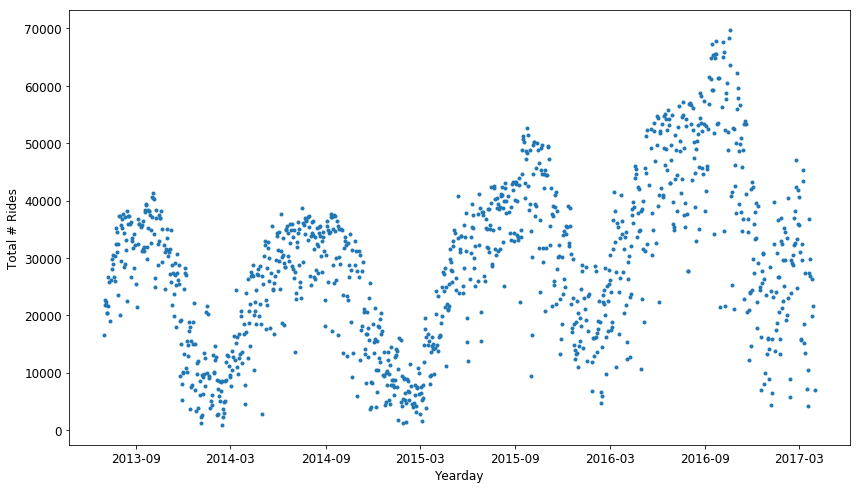

In [12]:
plt.figure(figsize=(14,8))
plt.plot(df_comb.date, df_comb.Nrides,'.');
plt.xlabel('Yearday')
plt.ylabel('Total # Rides');

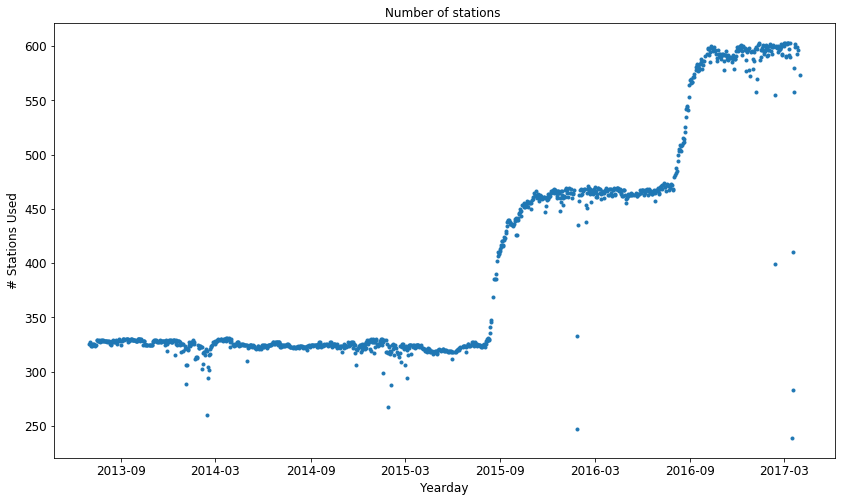

In [13]:
# Plot # stations vs yday (only counts tations that were used that day, so not necessarily
# all stations in service)
# NOTE spikes are likely days where not many rides taken
# should smooth these?
plt.figure(figsize=(14,8))
plt.plot(df_comb.date, df_comb.N_stations, '.');
plt.xlabel('Yearday')
plt.ylabel('# Stations Used');
plt.title('Number of stations ');

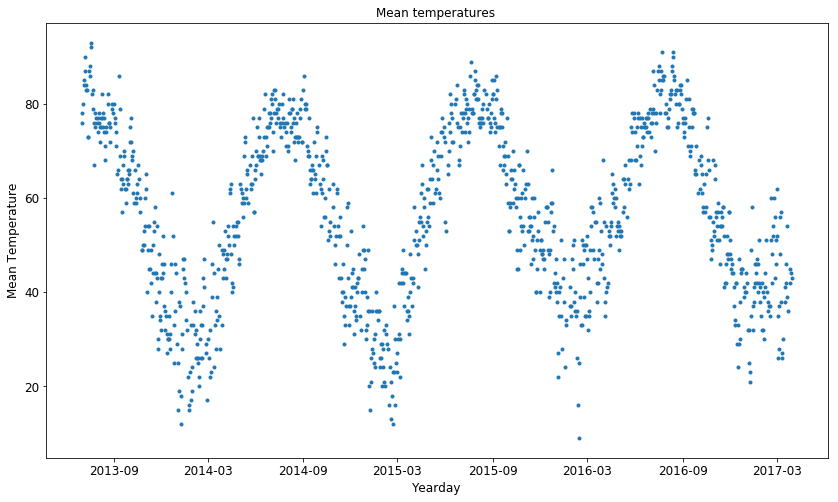

In [14]:
# Plot mean temperatures
plt.figure(figsize=(14,8))
plt.plot(df_comb.date, df_comb.Tmean,'.');
plt.xlabel('Yearday')
plt.ylabel('Mean Temperature');
plt.title('Mean temperatures ' );

### Now write df_comb to csv for loading during modeling

In [15]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1175
Data columns (total 15 columns):
yday            1176 non-null int64
Nrides          1176 non-null int64
date            1176 non-null datetime64[ns]
Tmean           1176 non-null int64
precip_In       1176 non-null float64
max_gust_mph    1173 non-null float64
cloud_cover     1176 non-null int64
N_stations      1176 non-null int64
wkday_1         1176 non-null uint8
wkday_2         1176 non-null uint8
wkday_3         1176 non-null uint8
wkday_4         1176 non-null uint8
wkday_5         1176 non-null uint8
wkday_6         1176 non-null uint8
public          1176 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5), uint8(6)
memory usage: 98.8 KB


In [16]:
df_comb.to_csv('data/data_comb.csv',index=False)